Ben Steves, CS 344, 2-23-22

# Train Simple Image Classifier

Task: Train a simple image classifier using cross-entropy loss

## Setup

In [1]:
from fastai.vision.all import *
from fastbook import *

# Input tensors get tagged as `TensorImageBW`, and they keep that tag even after going through the model.
# I'm not sure how you're supposed to drop that tag, but this works around a type dispatch error.
TensorImageBW.register_func(F.cross_entropy, TensorImageBW, TensorCategory)

import sys
if sys.platform == "darwin":
    # https://stackoverflow.com/a/64855500/69707
    import os
    os.environ['OMP_NUM_THREADS'] = '1'

Load up the MNIST dataset. It has 10 digits.

In [2]:
path = untar_data(URLs.MNIST)
path

Path('/scratch/cs344/data/mnist_png')

Create a subset of the images, so we train faster. We do this by taking 500 random images of each digit.

In [3]:
set_seed(0) #set random replicable seed
num_imgs_per_digit = 500
items = L([
    p
    for split in ['training', 'testing']
    for digit in range(10)
    for p in (path/split/str(digit)).ls().shuffle()[:num_imgs_per_digit] #take 500 random images from ds
])

Create the `dataloaders`. We need a slightly special `ImageBlock` because we want grayscale images.

In [4]:
block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock), #input is image, output is category
    get_y = parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name="testing"), #train/3/3434.png
)
dataloaders = block.dataloaders(items, bs=16) # put block into data loaders and batch size is 16
print(f"{dataloaders.train.n} training images, {dataloaders.valid.n} validation images")

5000 training images, 5000 validation images


Let's inspect a batch of data.

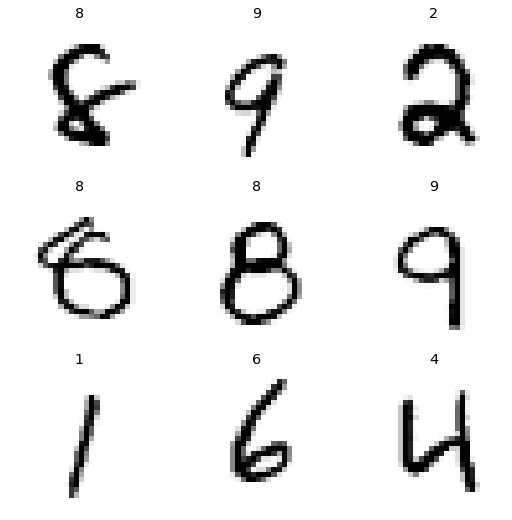

In [5]:
dataloaders.train.show_batch() #some images

In [6]:
print(f"Available categories: {dataloaders.train.vocab}") #believe this gives all possible values to classify

Available categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Task



Let's make a neural network to predict which digit was written, using the raw pixel values. We'll keep it at a *single* layer today, so this is actually just a fancy way of doing *logistic regression*. But it'll give us a chance to work with minibatches and loss functions.

Step 1: Create a linear layer of the appropriate dimensionality.

- Like we did in Homework 4, we'll flatten the images before giving them to the linear layer. They are 28 pixels square.
- Unlike in Homework 4, we're trying to predict which of 10 digits. So think about the output dimensionality.
- We'll turn `bias` off because it's redundant in this setting.

In [7]:
linear_1 = nn.Linear(in_features=28*28, out_features=10, bias=False)
model = nn.Sequential(
    nn.Flatten(),
    linear_1,
)
model.to('cuda')

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=False)
)

We test out our model on one batch of data.

In [8]:
images, labels = dataloaders.train.one_batch() #one batch
images = TensorBase(images) # work around a fastai quirk
images.shape #batch size, color shannel, dimx, dimy

torch.Size([16, 1, 28, 28])

In [9]:
logits = model(images) #run the model on the images
assert logits.shape == (16, 10) #shape is batchsize, output features
logits.shape
#logits

torch.Size([16, 10])

Think about why `logits.shape` contains those two numbers. 

In [10]:
labels #16 of our images

TensorCategory([0, 9, 8, 6, 0, 6, 8, 3, 1, 6, 5, 0, 0, 7, 7, 9], device='cuda:0')

Now let's compute the cross-entropy loss. We'll use [`F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy) from PyTorch, which has the following basic signature (simplified somewhat from the official docs):

```python
F.cross_entropy(
  logits: Tensor[Batch, Categories], # the unnormalized scores of each class, for each item in the batch
  target: TensorCategory[Batch],     # the correct label index (an int) for each item in the class
  reduction: str = 'mean'            # whether to return a single number for the average loss across the batch ('mean') or not ('none')
  label_smoothing: float = 0.0       # how much label smoothing to apply (none by default)
)
```

Let's try it on our logits and labels for this batch. (I'm unsure why it's still a `TensorCategory`, it should just be a normal `Tensor`.)

In [11]:
loss = F.cross_entropy(logits, labels)
loss

TensorCategory(2.3661, device='cuda:0', grad_fn=<AliasBackward0>)

In [12]:
loss.mean()

TensorCategory(2.3661, device='cuda:0', grad_fn=<AliasBackward0>)

We can use `argmax` to ask *which* category got the highest probability for each label. This will be useful for compting a *metric* like accuracy.

In [13]:
predictions = logits.argmax(dim=1)
print(predictions.shape)
predictions

torch.Size([16])


TensorBase([7, 8, 1, 8, 7, 8, 0, 7, 1, 7, 1, 4, 5, 4, 1, 2], device='cuda:0')

Now, fill in the blanks in the code below to train the model.

Epoch  0: loss=0.59, train accuracy 4118/4992
Epoch  1: loss=0.48, train accuracy 4436/4992
Epoch  2: loss=0.43, train accuracy 4523/4992
Epoch  3: loss=0.40, train accuracy 4555/4992
Epoch  4: loss=0.38, train accuracy 4592/4992
Epoch  5: loss=0.36, train accuracy 4601/4992
Epoch  6: loss=0.35, train accuracy 4641/4992
Epoch  7: loss=0.33, train accuracy 4630/4992
Epoch  8: loss=0.32, train accuracy 4664/4992
Epoch  9: loss=0.31, train accuracy 4642/4992


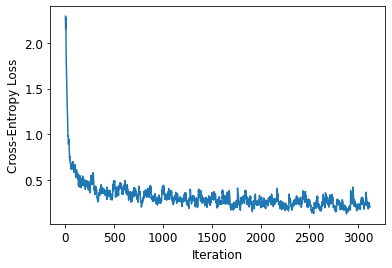

In [14]:
num_epochs = 10
learning_rate = 0.25
losses = []

# Re-initialize the parameters of the model, so training restarts when this block starts.
linear_1.reset_parameters()
for epoch in range(num_epochs):
    # Keep track of some things for each epoch.
    total_images = 0
    total_correct = 0
    for images, labels in dataloaders.train:
        images = TensorBase(images) # work around a quirk in fastai, ignore this
        logits = model(images)
        loss = F.cross_entropy(logits, labels, reduction='mean')

        # take an SGD step.
        loss.backward()
        for parameter in model.parameters():
            parameter.data -= learning_rate * parameter.grad
        model.zero_grad()

        # Track metrics
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images += len(labels)
        total_correct += num_accurate

        # Track losses.
        losses.append(loss.item())

    # Epoch done, print some stats.
    avg_loss_this_epoch = np.mean(losses[-total_images:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, train accuracy {total_correct:3d}/{total_images}")

# Plot the un-smoothed loss
#plt.plot(losses)
# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");

Let's inspect the weights of our trained network. Since we have a single layer, it's relatively easy to do this. First, look at the weights of the `linear_1` layer:

In [15]:
linear_1.weight.shape

torch.Size([10, 784])

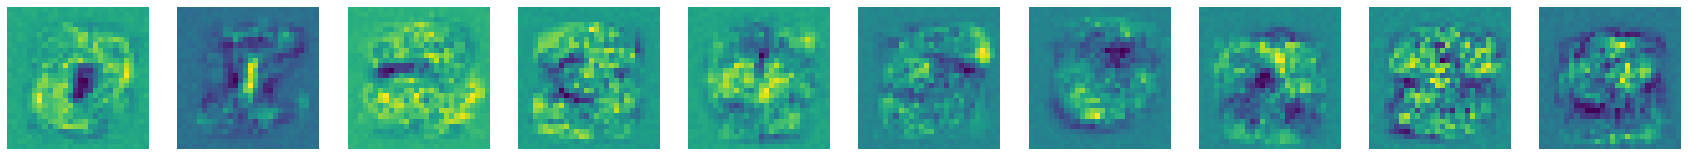

In [16]:
weight_images = linear_1.weight.data.view((10, 28, 28))
show_images(weight_images)

## Analysis

Q1: Why is `logits.shape` 16 by 10?

We used a batch size of 16, and we classified to ten categories

Q2:  Before we trained the model (i.e., it just had random weights), the cross entropy was all about the same number. What was that number, and why? Hint:

In [17]:
np.log(10)

2.302585092994046

My guess is that there was equal probability for any of the ten values to be predicted - there was not a lot of deviation between predicted probabilities so the weights don't differ all that much.

Q3: Adjust the learning rate parameter. Give an example of a learning rate that is too high, one that is too low, and one that is good. For each, explain your answer by describing what the loss curve looks like.

Too high: I did 8, but anything potentially anything > 1 is also not great. For starters, entropy starts off really high and does not fall near 0. It very quickly lingers around a cross entropy of 10 and doesn't fall too much after. 

Too low: 0.001. The curve is learning too slow to be able to give a confident and mostly constant cross entropy.

Just right: 0.25 returned very low loss values, with a curve that did quickly hit near 0 but wasn't outrageously high like 8 was. It was also more accurate than the previous two. 

Q4: Why the weight images look the way they do? (Why might they look similar to the digits in question? Why might they look not exactly like the digits in question?)

The weights at the end show mainly the predicted clusters of pixel values by numbers, and are based off the input data. They look like the data because they are based off of the data, but are not perfect replicas of each because 1) some numbers in the batch looked slightly different (same shapes but in potentially different locations), and 2) predictions are not perfectly replicable.